<style>
.jp-Notebook {
    padding: var(--jp-notebook-padding);
    margin-left: 160px;
    outline: none;
    overflow: auto;
    background: var(--jp-layout-color0);
}
</style>

# Setup and Data    

In [1]:
import pandas as pd
import autograd.numpy as np
from autograd import grad

awards = pd.read_csv("awards_data.csv")
player_data = pd.read_csv("player_stats.csv")

# Some cleaning of data where players are entered with two different names
player_data['player'] = np.where(player_data['player'] == 'Luka Dončić', 'Luka Doncic', player_data['player'])
player_data['player'] = np.where(player_data['player'] == 'RJ Barrett', 'R.J. Barrett', player_data['player'])

## Part 1 -- Awards  

### Question 1  

**QUESTION:** What is the average number of points per game for players in the 2007-2021 seasons who won All NBA First, Second, and Third teams (**not** the All Defensive Teams), as well as for players who were in the All-Star Game (**not** the rookie all-star game)?


 

In [2]:
# Fill NaN values with values that are compatible with apply(int)
awards = awards.fillna(-1)

# Use shared columns of player_data and awards to reassign indices allowing for seamless referencing
player_data.index = player_data['nbapersonid'].apply(str)+player_data['season'].apply(str)
awards.index = awards['nbapersonid'].apply(int).apply(str)+awards['season'].apply(str)

# Calculate points per game for each player in the dataset
player_data['ppg'] = player_data['points'] / player_data['games']

# Create separate dataframes for players with the specified honors
first_team = awards.query("`All NBA First Team`== 1")
second_team = awards.query("`All NBA Second Team`== 1")
third_team = awards.query("`All NBA Third Team`== 1")
all_star = awards.query("all_star_game == 1")
mvp = awards.query("`Most Valuable Player_rk` == 1")
dpoy = awards.query("`Defensive Player Of The Year_rk` == 1")

# Output the scoring averages of each award group
print('First Team Scoring Average:', player_data.loc[first_team.index]['ppg'].mean())
print('Second Team Scoring Average:', player_data.loc[second_team.index]['ppg'].mean())
print('Third Team Scoring Average:', player_data.loc[third_team.index]['ppg'].mean())
print('All-Star Scoring Average:', player_data.loc[all_star.index]['ppg'].mean())


First Team Scoring Average: 25.852444168634054
Second Team Scoring Average: 23.081536669102263
Third Team Scoring Average: 20.50349090652792
All-Star Scoring Average: 21.57878168665379


<strong><span style="color:red">ANSWER 1:</span></strong>   

1st Team: 25.9 points per game  
2nd Team: 23.1 points per game  
3rd Team: 20.5 points per game  
All-Star: 21.6 points per game  

### Question 2  

**QUESTION:** What was the average number of years of experience in the league it takes for players to make their first All NBA Selection (1st, 2nd, or 3rd team)? Please limit your sample to players drafted in 2007 or later who did eventually go on to win at least one All NBA selection. For example:

- Luka Doncic is in the dataset as 2 years. He was drafted in 2018 and won his first All NBA award in 2019 (which was his second season).  
- LeBron James is not in this dataset, as he was drafted prior to 2007.  
- Lu Dort is not in this dataset, as he has not received any All NBA honors.  



In [3]:
# Get the index values for all All-NBA Selections
all_nba_index = pd.concat([first_team, second_team, third_team]).index

# Retrieve the players from player_data and filter out those drafted before 2007
all_nba = player_data.loc[all_nba_index].query('draftyear >= 2007')

# Create a column signifying the nth season of the player in each row
all_nba['years_in_league'] = all_nba['season']-all_nba['draftyear']+1

# Sort dataframe so that each player's first All-NBA selection appears first
first_time_selections = all_nba.sort_values(['player', 'years_in_league']).drop_duplicates(subset=['player'])

# Drop duplicates so that only those first selections remain to compute average
first_time_selections = first_time_selections.drop_duplicates(subset=['player'])['years_in_league']
print('Average Years for First All-NBA Selection:', first_time_selections.mean())


Average Years for First All-NBA Selection: 4.682926829268292


<strong><span style="color:red">ANSWER 2:</span></strong>  

4.7 Years  

## Data Cleaning Interlude- Career Outcomes

- Elite: A player is "Elite" in a season if he won any All NBA award (1st, 2nd, or 3rd team), MVP, or DPOY in that season.    
- All-Star: A player is "All-Star" in a season if he was selected to be an All-Star that season.   
- Starter:  A player is a "Starter" in a season if he started in at least 41 games in the season OR if he played at least 2000 minutes in the season.    
- Rotation:  A player is a "Rotation" player in a season if he played at least 1000 minutes in the season.   
- Roster:  A player is a "Roster" player in a season if he played at least 1 minute for an NBA team but did not meet any of the above criteria.     
- Out of the League: A player is "Out of the League" if he is not in the NBA in that season.   

We need to make an adjustment for determining Starter/Rotation qualifications for a few seasons that didn't have 82 games per team. Assume that there were 66 possible games in the 2011 lockout season and 72 possible games in each of the 2019 and 2020 seasons that were shortened due to covid. Specifically, if a player played 900 minutes in 2011, he **would** meet the rotation criteria because his final minutes would be considered to be 900 * (82/66) = 1118. Please use this math for both minutes and games started, so a player who started 38 games in 2019 or 2020 would be considered to have started 38 * (82/72) = 43 games, and thus would qualify for starting 41. Any answers should be calculated assuming you round the multiplied values to the nearest whole number.

Note that on a season level, a player's outcome is the highest level of success he qualifies for in that season. Thus, since Shai Gilgeous-Alexander was both All-NBA 1st team and an All-Star last year, he would be considered to be "Elite" for the 2022 season, but would still qualify for a career outcome of All-Star if in the rest of his career he made one more All-Star game but no more All-NBA teams. Note this is a hypothetical, and Shai has not yet played enough to have a career outcome.    

Examples:  

- A player who enters the league as a rookie and has season outcomes of Roster (1), Rotation (2), Rotation (3), Roster (4), Roster (5), Out of the League (6+) would be considered "Out of the League," because after his first four seasons, he only has a single Roster year, which does not qualify him for any success outcome.  
- A player who enters the league as a rookie and has season outcomes of Roster (1), Rotation (2), Starter (3), Starter (4), Starter (5), Starter (6), All-Star (7), Elite (8), Starter (9) would be considered "All-Star," because he had at least two seasons after his first four at all-star level of production or higher.  
- A player who enters the league as a rookie and has season outcomes of Roster (1), Rotation (2), Starter (3), Starter (4), Starter (5), Starter (6), Rotation (7), Rotation (8), Roster (9) would be considered a "Starter" because he has two seasons after his first four at a starter level of production. 


### Question 3  

**QUESTION:** There are 73 players in the `player_data` dataset who have 2010 listed as their draft year. How many of those players have a **career** outcome in each of the 6 buckets?  

In [4]:
# Create indicator columns for each shortened season
eleven = player_data['season'] == 2011
nineteen = player_data['season'] == 2019
twenty = player_data['season'] == 2020

# Create columns calculating the adjustment for covid/lockout seasons
lockout_games = round(player_data['games_start']*82/66)
covid_games = round(player_data['games_start']*82/72)
lockout_mins = round(player_data['mins']*82/66)
covid_mins = round(player_data['mins']*82/72)

# Make necessary adjustments for seasons in question
player_data['adj_games_start'] = np.where(eleven, lockout_games, player_data['games_start'])
player_data['adj_games_start'] = np.where(nineteen | twenty, covid_games, player_data['adj_games_start'])
player_data['adj_mins'] = np.where(eleven, lockout_mins, player_data['mins'])
player_data['adj_mins'] = np.where(nineteen | twenty, covid_mins, player_data['adj_mins'])

# Create columns determining whether a player qualified for any given bucket during a season
player_data['Elite'] = player_data.index.isin(pd.concat([first_team, second_team, third_team, mvp, dpoy]).index)
player_data['All-Star'] = player_data.index.isin(all_star.index)
player_data['Starter'] = (player_data['adj_games_start'] >= 41) | (player_data['adj_mins'] >= 2000)
player_data['Rotation'] = player_data['adj_mins'] >= 1000
player_data['Roster'] = player_data['adj_mins'] >= 1

# Filter out seasons 1-4 for each player
filtered_player_data = player_data.query('season - draftyear + 1 > 4')
filtered_player_data = filtered_player_data.sort_values(['player', 'season'])

# This is where each player's outcome will be stored
career_outcomes = filtered_player_data[['player', 'draftyear', 'draftpick', 'nbapersonid']]
career_outcomes = career_outcomes.drop_duplicates(subset=['player', 'draftyear'])

# Create a function determining the outcome of a career
def outcome(career):
    if career['Elite'].sum() >= 2:
        return 'Elite'
    if (career['All-Star'] | career['Elite']).sum() >= 2:
        return 'All-Star'
    if (career['Starter'] | career['All-Star'] | career['Elite']).sum() >= 2:
        return 'Starter'
    if (career['Rotation'] | career['Starter'] | career['All-Star'] | career['Elite']).sum() >= 2:
        return 'Rotation'
    if career['Roster'].sum() >= 2:
        return 'Roster'
    return 'Out of League'

# Group player data to create dataframes representing the careers of each player and compute outcomes
players = filtered_player_data.groupby(['player', 'draftyear'])
career_outcomes['Elite'] = [career['Elite'].sum() >= 2 
                            for player, career in players]

career_outcomes['All-Star'] = [(career['All-Star'] | career['Elite']).sum() >= 2 
                               for player, career in players]

career_outcomes['Starter'] = [(career['Starter'] | career['All-Star'] | career['Elite']).sum() >= 2 
                              for player, career in players]

career_outcomes['Rotation'] = [(career['Rotation'] | career['Starter'] | career['All-Star'] | career['Elite']).sum() >=2
                               for player, career in players]

career_outcomes['Roster'] = [career['Roster'].sum() >= 2 
                             for player, career in players]

career_outcomes['outcome'] = [outcome(career) for player, career in players]

# Get 2010 draft class breakdown
ten_class = career_outcomes.query("draftyear == 2010")
print('Elite:', len(ten_class.query("outcome == 'Elite'")))
print('All-Star:', len(ten_class.query("outcome == 'All-Star'")))
print('Starter:', len(ten_class.query("outcome == 'Starter'")))
print('Rotation', len(ten_class.query("outcome == 'Rotation'")))
print('Roster:', len(ten_class.query("outcome == 'Roster'")))
ten_class

Elite: 2
All-Star: 1
Starter: 11
Rotation 7
Roster: 15


,player,draftyear,draftpick,nbapersonid,Elite,All-Star,Starter,Rotation,Roster,outcome
2023292014,Al-Farouq Aminu,2010,8.0,202329,False,False,True,True,True,Starter
2031442014,Alexey Shved,2010,NaN,203144,False,False,False,False,True,Roster
2026202014,Arinze Onuaku,2010,NaN,202620,False,False,False,False,True,Roster
2023402014,Avery Bradley,2010,19.0,202340,False,False,True,True,True,Starter
16262462015,Boban Marjanovic,2010,NaN,1626246,False,False,False,False,True,Roster
2023322014,Cole Aldrich,2010,11.0,202332,False,False,False,False,True,Roster
2023262014,DeMarcus Cousins,2010,5.0,202326,True,True,True,True,True,Elite
2023242014,Derrick Favors,2010,3.0,202324,False,False,True,True,True,Starter
2023882014,Donald Sloan,2010,NaN,202388,False,False,False,True,True,Rotation
2023342014,Ed Davis,2010,13.0,202334,False,False,False,True,True,Rotation


<strong><span style="color:red">ANSWER 3:</span></strong>  

Elite: 2 players.  
All-Star: 1 players.  
Starter: 11 players.  
Rotation: 7 players.  
Roster: 15 players.  
Out of League: 37 players.  

### Building a model to predict career outcomes

### Strengths
- The model is able to predict the probability a given player will fall into any career bucket
- The coefficients used to fit the conditional probabilities allow varying of the importance of certain features once certain thresholds are cleared
- The model is able to incorporate the amount of years a player has been in the league

### Weaknesses
- The model doesn't take into account age therefore assuming all rookies are the same age and so on. With this data available I could introduce another temperature code or continuous feature for age
- The model doesn't consider interactions between features. With more time, a deep/wide neural network could be trained and/or more features could be added considering the interactions
- The data only goes back to 2007. More data might be helpful to capture more patterns
- No possession based data other than BPM/VORP. Players in 2007 for example had a slower pace therefore lower averages all around which might overrate players drafted more recently. Per 100 possessions stats would mitigate this.
- The model doesn't take into account career trajectory. More features could be added to describe improvement by year but earlier data from college/high school/overseas would be required especially for players drafted in 2020-2021
- The model doesn't like Josh Giddey :(

In [5]:
# Define column names for the input data
columns = ['games', 'starts', 'mins']
total_stats = ['fgm3', 'fga3', 'fgm2', 'fga2', 'ftm', 'fta', 'off_reb', 'def_reb', 'ast', 'steals', 'blocks', 'tov', 
               'tot_fouls', 'points', 'OWS', 'DWS'] 
columns += total_stats 
columns += [c+'_pg' for c in columns[1:]]+[c+'_per_36' for c in columns[3:]]
columns += ['start_pct', 'ftr']
columns += ['weighted_per', 'weighted_usg', 'weighted_obpm', 'weighted_dbpm', 'weighted_vorp']
columns += ['4+', '3+', '2+']

# Function that gathers career data for each player up to a given year of experience
def gather_data(experience):
    # Define thermometer code determining how many years each of the gathered players has been in the league
    temperature = [0]*(4-experience)+[1]*(experience-1)
    
    # Filter the player data so that only seasons completed by players up to the given experience
    # On top of limiting to players drafted before 2015 as specified, only look at players drafted after 2007 so that
    # their entire early career is captured 
    training_data = player_data.query('draftyear <= 2015 & draftyear >= 2007 & season-draftyear+1 <= @experience')
    
    # Add a column to training data that will multiply totals for each stat in COVID and lockdown years
    mult = np.where(training_data['season'] == 2011, 82/66, 1)
    mult = np.where((training_data['season'] == 2019) | (training_data['season'] == 2020), 82/72, mult)
    training_data['mult'] = mult
    
    # Split the training data into groups where each group contains a player's early career
    training_data_groups = training_data.sort_values(['player', 'season']).groupby('player')
    
    # Initialize the input matrix X and its index
    X = []
    index = [] 
    
    # Loop through each group to gather input data
    for player, early_career in training_data_groups:
        # Add player to index
        index.append(player)
        
        # Gather total number of seasons, games, starts and minutes adjusted by mutltiplier as initial features
        seasons = len(early_career['season'].unique())
        games = (early_career['games']*early_career['mult']).sum() / seasons
        starts = (early_career['games_start']*early_career['mult']).sum() / seasons
        mins = (early_career['mins']*early_career['mult']).sum() / seasons
        total_row = [games, starts, mins]
        
        # For each stat in total_stats defined above, calculate totals per season, per game, and per 36
        total_row += list(np.array([(early_career[stat]*early_career['mult']).sum() for stat in total_stats]) / seasons)
        per_game_row, per_36_row = list(np.array(total_row[1:]) / games), list(np.array(total_row[3:]) / mins * 36)

        # Add features for percentage of games started and free throw rate
        start_pct = starts / games
        ftr = early_career['ftm'].sum() / early_career['fga'].sum()
        ratio_row = [start_pct, ftr]
        
        # For certain advanced metrics that shouldn't be summed, compute weighted sum based on minutes played
        weighted_per = (early_career['PER']*early_career['mins']).sum()/mins
        weighted_usg = (early_career['usg']*early_career['mins']).sum()/mins
        weighted_obpm = (early_career['OBPM']*early_career['mins']).sum()/mins
        weighted_dbpm = (early_career['DBPM']*early_career['mins']).sum()/mins
        weighted_vorp = (early_career['VORP']*early_career['mins']).sum()/mins
        weighted_row = [weighted_per, weighted_usg, weighted_obpm, weighted_dbpm, weighted_vorp]
        
        # Append each of the gathered features to X
        X.append(total_row+per_game_row+per_36_row+ratio_row+weighted_row+temperature)

    # Convert X to DataFrame
    X = pd.DataFrame(X, index=index, columns=columns).fillna(0)
    return X

# training_outcomes will contain the actual career outcomes for each player in the training set
training_outcomes = career_outcomes.query('draftyear <= 2015 & draftyear >= 2007')
training_outcomes.index = training_outcomes['player']
training_outcomes = training_outcomes.drop('player', axis=1)

# Gather data for players after 1 year completed, 2 years, 3, and 4
X = pd.concat([gather_data(i) for i in range(1,5)])

C:\Users\Bryant Ndongmo\AppData\Local\Temp\ipykernel_10320\1411286625.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['mult'] = mult
C:\Users\Bryant Ndongmo\AppData\Local\Temp\ipykernel_10320\1411286625.py:51: RuntimeWarning: invalid value encountered in longlong_scalars
  ftr = early_career['ftm'].sum() / early_career['fga'].sum()
C:\Users\Bryant Ndongmo\AppData\Local\Temp\ipykernel_10320\1411286625.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['mult'] = mult
C:\User

In [6]:
# Import libraries to scale data and fit model
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

scaler = StandardScaler()
scaler.fit(X)

# scaled_X will contain scaled values of X but the thermometer codes will not be standardized
scaled_X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)
scaled_X[['4+', '3+', '2+']] = X[['4+', '3+', '2+']]
scaled_X

,games,starts,mins,fgm3,fga3,fgm2,fga2,ftm,fta,off_reb,...,start_pct,ftr,weighted_per,weighted_usg,weighted_obpm,weighted_dbpm,weighted_vorp,4+,3+,2+
A.J. Price,0.445723,-0.634817,-0.009743,1.104497,1.164911,-0.178951,-0.175401,0.009602,-0.060613,-0.596570,...,-0.711056,-0.209105,-0.583822,-0.667809,0.708623,0.123816,-0.121788,0,0,0
Aaron Brooks,0.247451,-0.727812,-0.347235,0.389623,0.455653,-0.427698,-0.452298,-0.244061,-0.342916,-0.577268,...,-0.831448,-0.060387,-0.633267,-0.708946,0.634006,0.347759,-0.121788,0,0,0
Aaron Gordon,0.088833,-0.355834,-0.099041,-0.295466,-0.209958,-0.223370,-0.261931,-0.215876,-0.212622,0.059690,...,-0.257665,0.154975,-0.726663,-0.996907,0.242264,0.235787,-0.366641,0,0,0
Aaron Gray,0.643996,-0.681315,-0.340669,-0.682689,-0.722806,-0.019042,-0.075891,-0.046768,0.199974,0.522933,...,-0.776186,0.700237,-0.589316,-0.699804,0.055721,0.273111,-0.366641,0,0,0
Aaron Harrison,-0.942185,-0.727812,-1.023530,-0.593330,-0.624601,-0.916307,-0.915235,-0.765480,-0.744655,-0.750984,...,-0.831448,0.601942,-1.116727,-1.079181,-0.615836,0.609025,-0.317670,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xavier Munford,-1.378385,-0.727812,-0.971659,-0.548650,-0.597322,-0.827469,-0.828705,-0.779572,-0.788086,-0.789588,...,-0.831448,-0.842121,-0.369665,-0.051923,-0.612598,0.567194,-0.268699,1,1,1
Xavier Silas,-1.676394,-0.727812,-1.082027,-0.645682,-0.652376,-0.900962,-0.905795,-0.800924,-0.834478,-0.780229,...,-0.831448,-0.522195,-1.348541,-0.848188,-0.834229,-0.988614,-0.308115,1,1,1
Zabian Dowdell,-0.823221,-0.727812,-0.762204,-0.593330,-0.624601,-0.507652,-0.456624,-0.610463,-0.690366,-0.731682,...,-0.831448,-0.568375,-0.710181,-0.562680,-0.000243,0.347759,-0.317670,1,1,1
Zach LaVine,0.505205,0.946087,1.021443,1.864051,1.765052,0.929304,0.976533,0.974931,0.827012,-0.432505,...,1.279076,-0.028927,1.623587,2.533972,0.543373,-2.408817,-0.350572,1,1,1


In [7]:
# For every player in the training data, retrieve their label signifying the bucket they're in
# Labels are thermometer codes (All-Star=01111, Out of League=00000, etc)
def retrieve_outcomes(bucket):
    outcomes = []
    for index in X.index:
        if index in training_outcomes.index:
            outcomes.append(training_outcomes.loc[index][bucket])
        # Since career_outcomes only includes players who at least completed a season after year 4 some may not be in
        # They are thus out of the league
        else:
            outcomes.append(False)
    return outcomes

# Sigmoid function to be used to map output values of model to probabilities
def sigmoid(x):
    return np.array(1 / (1+np.exp(-x)))

# The fit model will predict p(roster) as well as conditional probabilities 
# p(elite|all star), p(all star|starter), p(starter|rotation), p(rotation|roster)
# All of these probabilities will determine the probability of landing in a given bucket
def fit(X, y, L1=[0]*5, L2=[0]*5):
    # Initialize coefficients to 0
    coef_init = [0.0]*(X.shape[1]*5)
    
    # Initialize intercepts to be the average conditional probabilities
    intercept_init = [y['Elite'].sum()/y['All-Star'].sum(), y['All-Star'].sum()/y['Starter'].sum(), 
                      y['Starter'].sum()/y['Rotation'].sum(), y['Rotation'].sum()/y['Roster'].sum(), y['Roster'].mean()]
    
    # Apply logit function since sigmoid will be applied to recover probabilities
    intercept_init = [np.log(p/(1-p)) for p in intercept_init]
    x0 = coef_init + intercept_init
    
    # Function we want to minimize
    def func(x):
        y_arr = np.array(y)
        
        # Retrieve coefficents and intercepts from flattened x array and use them to make predictions
        coefs = np.array([x[i:i+X.shape[1]] for i in range(0, X.shape[1]*5, X.shape[1])])
        intercepts = np.array(x[X.shape[1]*5:])
        preds = sigmoid(np.array(X)@coefs.T+intercepts)
        
        # Use conditional probabilities to determine the probability each player at least reaches any given bucket and
        # compute log likelihood
        neg_log_likelihood = 0
        
        elite = preds[:,0]*preds[:,1]*preds[:,2]*preds[:,3]*preds[:,4]
        neg_log_likelihood -= (y_arr[:,0]*np.log(elite)+(1-y_arr[:,0])*np.log(1-elite)).sum()
        
        all_star = elite/preds[:,0]
        neg_log_likelihood -= (y_arr[:,1]*np.log(all_star)+(1-y_arr[:,1])*np.log(1-all_star)).sum()
        
        starter = all_star/preds[:,1]
        neg_log_likelihood -= (y_arr[:,2]*np.log(starter)+(1-y_arr[:,2])*np.log(1-starter)).sum()
        
        rotation = starter/preds[:,2]
        neg_log_likelihood -= (y_arr[:,3]*np.log(rotation)+(1-y_arr[:,3])*np.log(1-rotation)).sum()
        
        roster = preds[:,4]
        neg_log_likelihood -= (y_arr[:,4]*np.log(roster)+(1-y_arr[:,4])*np.log(1-roster)).sum()
        
        # Compute penalty terms
        penalty1 = np.sum([L1[i]*(np.abs(coefs[i])).sum() for i in range(5)])
        penalty2 = np.sum([L2[i]*(coefs[i]**2).sum() for i in range(5)])
        
        # Return neg_log_likelihood+penalties
        return neg_log_likelihood+penalty1+penalty2
    
    # Use autograd to define gradient of func
    gradient = grad(func)
    
    # Find the function minimizing weights
    result = minimize(func, x0, jac=gradient, method='l-bfgs-b', options={'maxiter':10})
    x = result.x
    
    # Recover coefficients and weights to predict probabilities for each player in training set
    coefs = np.array([x[i:i+X.shape[1]] for i in range(0, X.shape[1]*5, X.shape[1])])
    intercepts = np.array(x[X.shape[1]*5:])
    preds = sigmoid(np.array(X)@coefs.T+intercepts)
    
    # Convert conditional probabilities to cumulative probabilities
    elite = preds[:,0]*preds[:,1]*preds[:,2]*preds[:,3]*preds[:,4]
    all_star = elite/preds[:,0]
    starter = all_star/preds[:,1]
    rotation = starter/preds[:,2]
    roster = preds[:,4]
    preds = np.vstack([elite, all_star, starter, rotation, roster]).T
    
    # Return predictions and weights
    preds = pd.DataFrame(preds, index=X.index, columns=buckets)
    experience = np.where(X['2+']==1,2,1)
    experience = np.where(X['3+']==1,3,experience)
    experience = np.where(X['4+']==1,4,experience)
    preds.index = [index+str(exp) for index, exp in zip(X.index, experience)]
    return preds, x
    
# Function to tune regularization hyperparameters with pseudo-Leave One Out Cross Validation
def LOOCV(L1, L2):
    # Initialize list to store LOOCV scores
    loocv_scores = []
    
    # Pseudo because as every player can have multiple data points, they must be all held out at once
    # to prevent data leakage
    for player in scaled_X.index.unique():
        # Train on all but 1 player
        X_train, y_train = scaled_X.drop(player, axis=0), outcomes.drop(player, axis=0)
        X_test, y_test = scaled_X.loc[player], outcomes.loc[player]

        # Fit 
        x = fit(X_train, y_train, L1,L2)[1]
        coefs = np.array([x[i:i+X.shape[1]] for i in range(0, X.shape[1]*5, X.shape[1])])
        intercepts = np.array(x[X.shape[1]*5:])
        pred = sigmoid(np.array(X_test)@coefs.T+intercepts)
        if len(pred.shape) == 1:
            pred = pred.reshape(-1,1).T
            y_test = pd.DataFrame(y_test).T
   
        elite = pred[:,0]*pred[:,1]*pred[:,2]*pred[:,3]*pred[:,4]
        all_star = elite/pred[:,0]
        starter = all_star/pred[:,1]
        rotation = starter/pred[:,2]
        roster = pred[:,4]
       
        # Compute error   
        pred = np.vstack([elite, all_star, starter, rotation, roster]).T 
        loss = np.log(pred)*y_test+np.log(1-pred)*(1-y_test)
        loocv_scores.append(-loss.sum(axis=1).mean())
        
        
    print(L1, L2, np.mean(loocv_scores))
    # Return average of LOOCV scores
    return np.mean(loocv_scores)


In [8]:
# Produce labels (thermometer codes) for each of the training points 
buckets = ['Elite', 'All-Star', 'Starter', 'Rotation', 'Roster']
y = pd.DataFrame([retrieve_outcomes(bucket) for bucket in buckets]).T            
y.index = X.index
y.columns = buckets
y

,Elite,All-Star,Starter,Rotation,Roster
A.J. Price,False,False,False,False,True
Aaron Brooks,False,False,False,True,True
Aaron Gordon,False,False,True,True,True
Aaron Gray,False,False,False,False,True
Aaron Harrison,False,False,False,False,False
...,...,...,...,...,...
Xavier Munford,False,False,False,False,False
Xavier Silas,False,False,False,False,False
Zabian Dowdell,False,False,False,False,False
Zach LaVine,False,True,True,True,True


In [9]:
# Function that was used to tune hyperparameters of model with a line search alternating between L1 and l2
# and going from "Roster" to "Elite|All Star"

def tune_hyperparameter(incumbent, i, j):
    patience = 2
    best = 10
    iters_since_improvement = 0
    k = 0
    while iters_since_improvement < patience:
        incumbent[i][j] = k
        score = LOOCV(incumbent[0], incumbent[1])
        if score < best:
            best = score
            iters_since_improvement = 0
            sol = [incumbent[0].copy(), incumbent[1].copy()]
        else:
            iters_since_improvement += 1
        k += 1

    return sol
#sol = tune_hyperparameter([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], 0, 4)
#sol = tune_hyperparameter(sol, 1, 4)
#sol = tune_hyperparameter(sol, 0, 3)
#sol = tune_hyperparameter(sol, 1, 3)
#sol = tune_hyperparameter(sol, 0, 2)
#sol = tune_hyperparameter(sol, 1, 2)
#sol = tune_hyperparameter(sol, 0, 1)
#sol = tune_hyperparameter(sol, 1, 1)
#sol = tune_hyperparameter(sol, 0, 0)
#sol = tune_hyperparameter(sol, 1, 0)


In [10]:
# Make predictions on trained model with tuned hyperparameters
predictions, x = fit(scaled_X,y,[0, 9, 3, 11, 12], [0, 0, 12, 3, 2])
predictions.sort_values('Elite', ascending=False).iloc[:20]


,Elite,All-Star,Starter,Rotation,Roster
Kevin Durant4,0.887597,0.977002,0.997868,0.999507,0.999977
Kevin Durant3,0.851490,0.959669,0.995871,0.998798,0.999928
James Harden4,0.788667,0.928893,0.986710,0.996779,0.999782
Anthony Davis4,0.779790,0.851544,0.989682,0.998981,0.999913
Anthony Davis3,0.758877,0.827396,0.987177,0.998630,0.999881
Blake Griffin2,0.745947,0.872015,0.978733,0.995377,0.999755
Karl-Anthony Towns4,0.735972,0.866163,0.984920,0.998827,0.999989
Blake Griffin3,0.673021,0.802218,0.973177,0.996167,0.999837
Blake Griffin4,0.671305,0.799708,0.977106,0.997388,0.999878
Joel Embiid4,0.668875,0.785688,0.924614,0.955404,0.991079


C:\Users\Bryant Ndongmo\AppData\Local\Temp\ipykernel_10320\2422516453.py:6: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  losses = (y*np.log(predictions)+(1-y)*np.log(1-predictions)).sum(axis=1).sort_values(0)


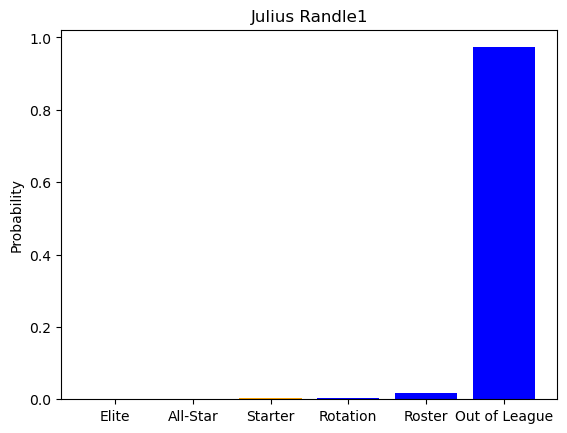

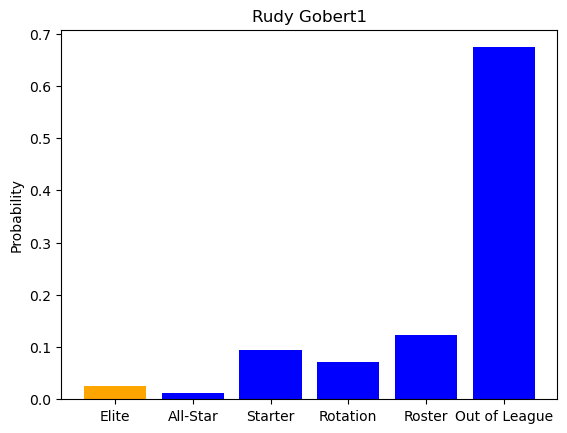

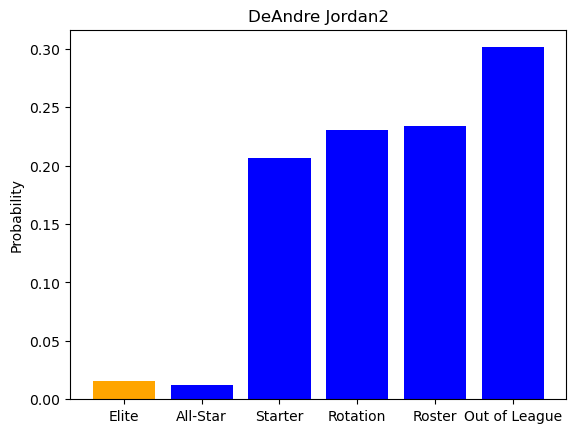

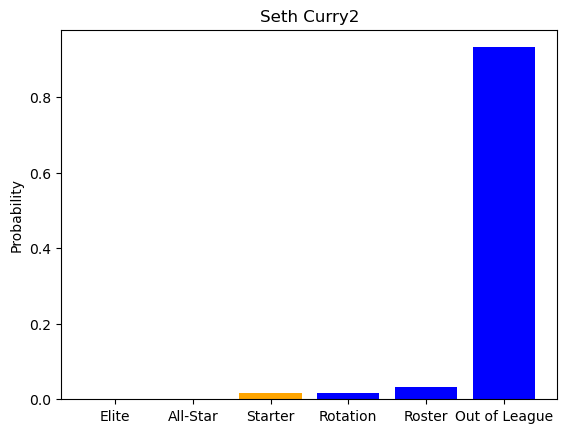

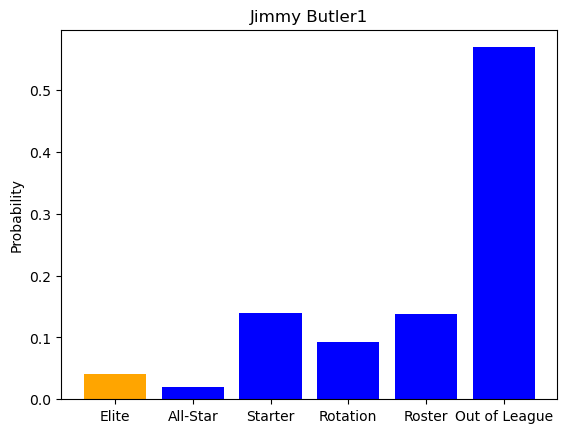

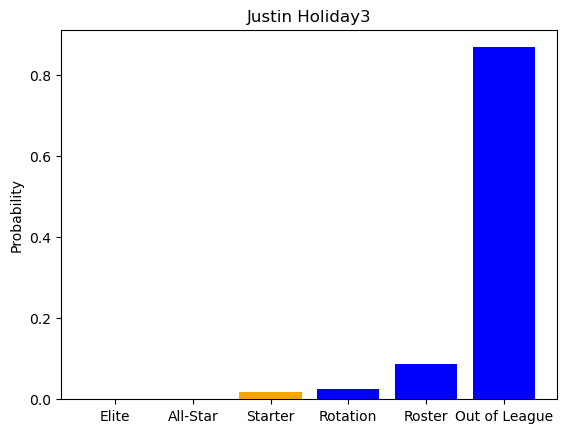

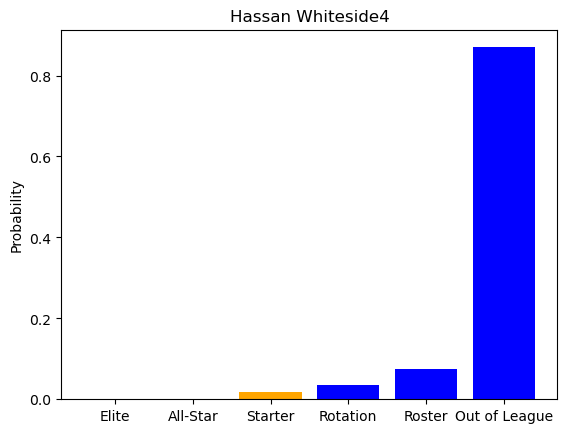

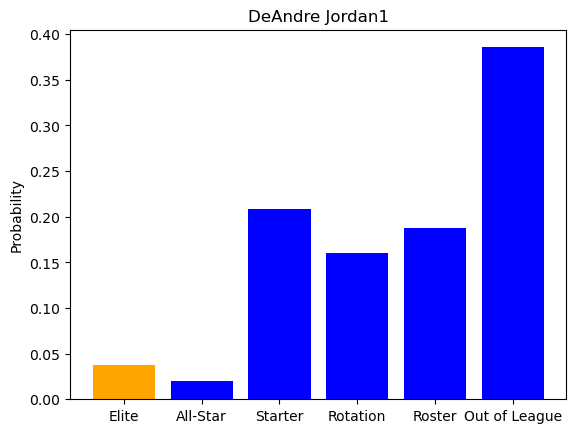

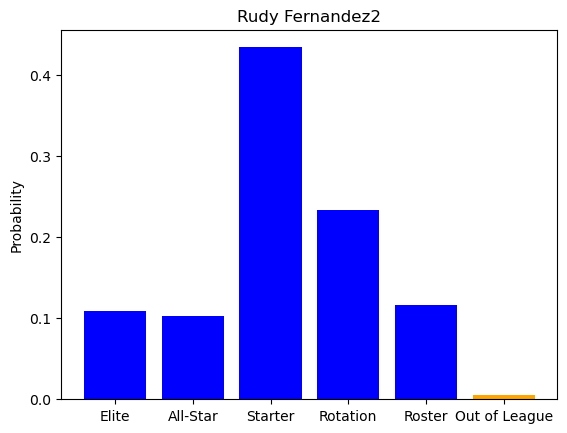

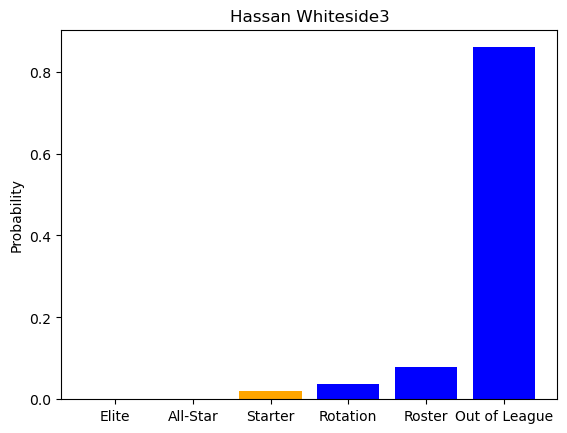

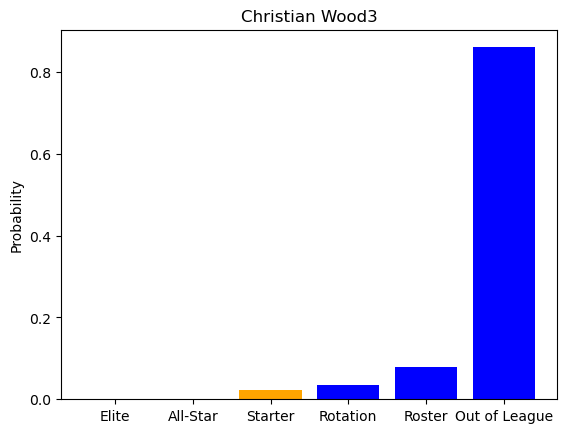

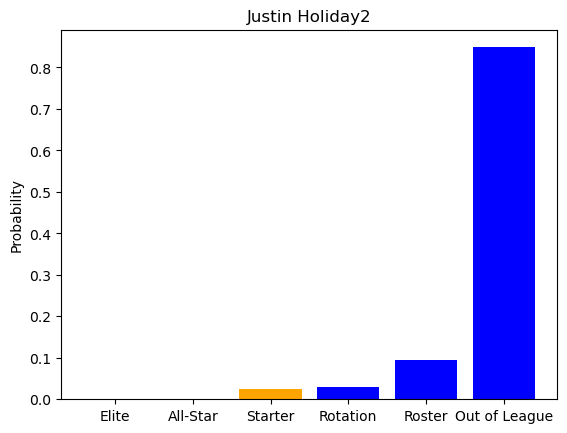

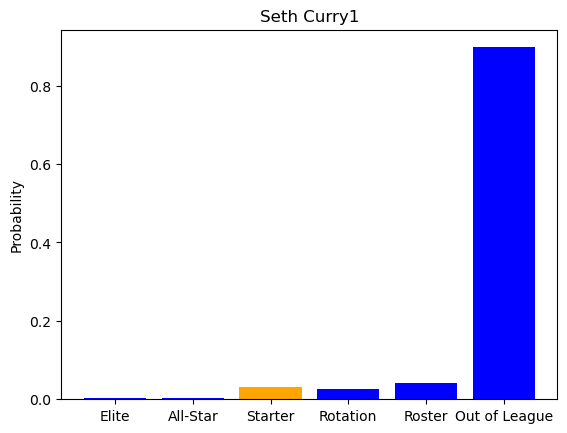

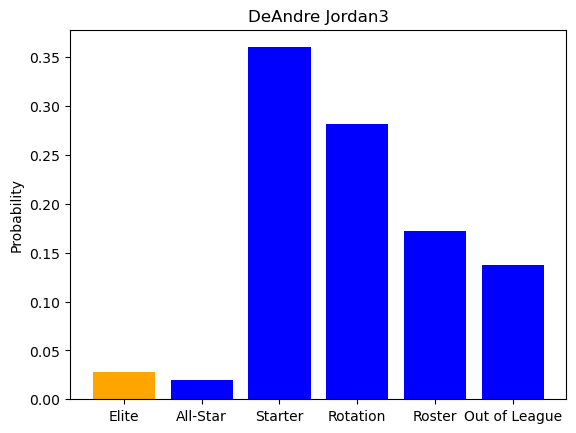

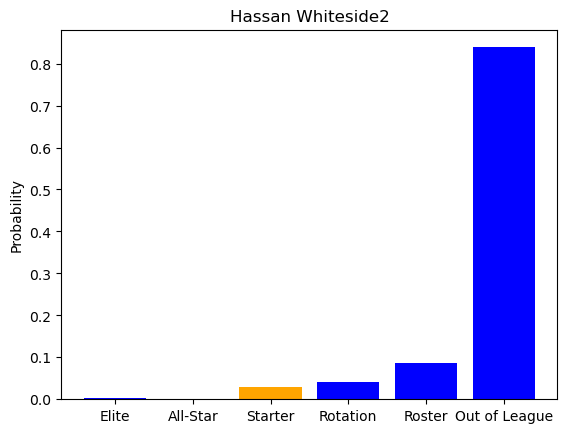

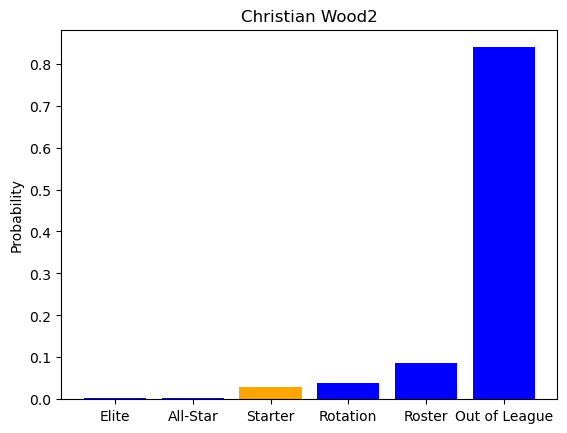

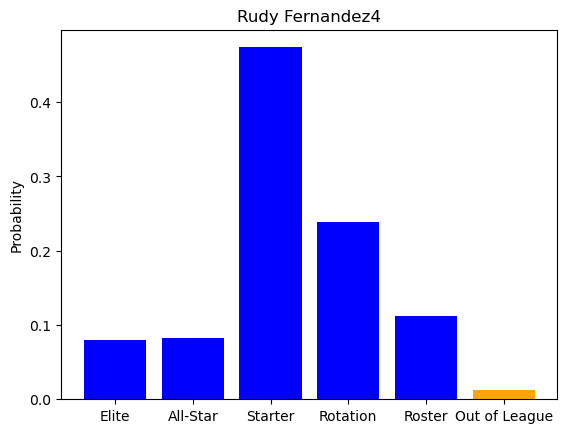

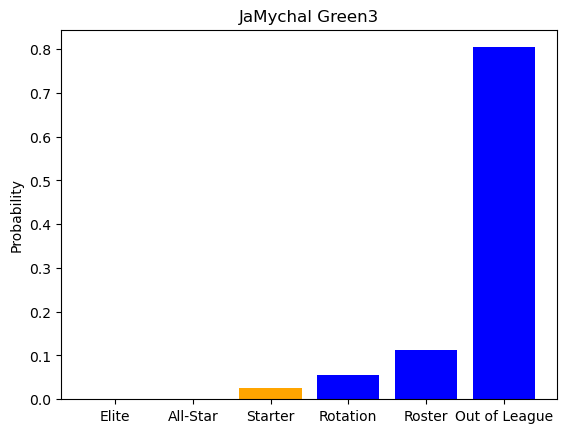

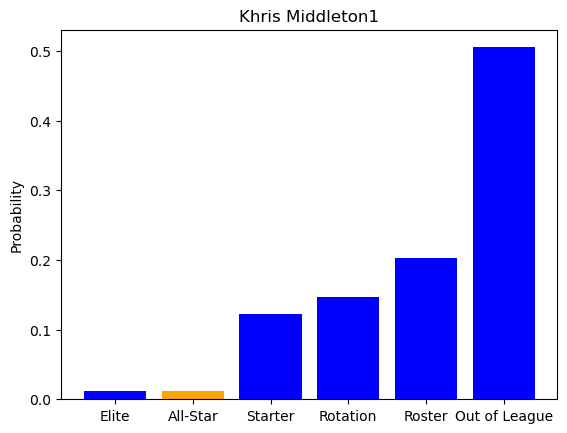

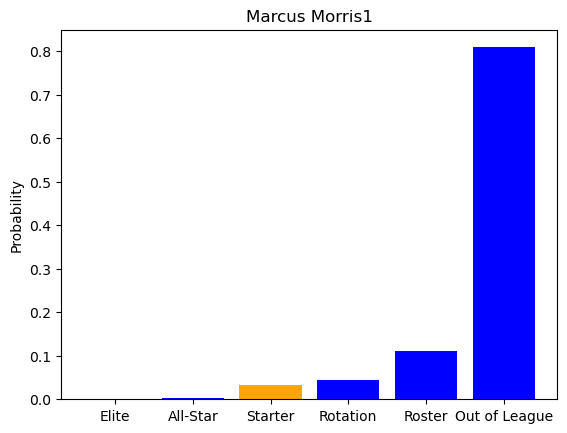

In [11]:
# Import matplotlib to make visualizations
import matplotlib.pyplot as plt

# Determine the most inaccurate predictions on the training data
y.index = predictions.index
losses = (y*np.log(predictions)+(1-y)*np.log(1-predictions)).sum(axis=1).sort_values(0)
bad_predictions = predictions.loc[losses.index[:20]]
actual_outcomes = y.loc[losses.index[:20]]
bad_predictions['All-Star'] -= bad_predictions['Elite']
bad_predictions['Starter'] -= bad_predictions['Elite']+bad_predictions['All-Star']
bad_predictions['Rotation'] -= bad_predictions['Elite']+bad_predictions['All-Star']+bad_predictions['Starter']
bad_predictions['Roster'] -= (bad_predictions['Elite']+bad_predictions['All-Star']+bad_predictions['Starter']
                              +bad_predictions['Rotation'])
bad_predictions['Out of League'] = 1 - (bad_predictions['Elite']+bad_predictions['All-Star']+bad_predictions['Starter']
                                        +bad_predictions['Rotation']+bad_predictions['Roster'])

# Display the predicted probability distributions for the bad predictions as well as the actual outcome achieved
# highlighted in orange
for index, row in bad_predictions.iterrows():
    actual = actual_outcomes.loc[index]
    colors = ['orange' if value else 'blue' for value in actual]+['orange']
    for i, color in enumerate(colors):
        if color == 'orange':
            for j in range(i+1, len(colors)):
                colors[j] = 'blue'
            break
    plt.bar(buckets+['Out of League'], row, color=colors)
    plt.title(index)
    plt.ylabel('Probability')
    plt.show()

# Randle played 14 minutes his rookie season due to injury
# Julius Randle1 means his career projection after his 1st season

In [12]:
# Gather data for players drafted from 2018-2021 to predict on
test_data = player_data.query('draftyear <= 2021 & draftyear >= 2018 & season-draftyear+1 <= 4')

# Gather test data just as the training data was
mult = np.where(test_data['season'] == 2011, 82/66, 1)
mult = np.where((test_data['season'] == 2019) | (test_data['season'] == 2020), 82/72, mult)
test_data['mult'] = mult
test_data_groups = test_data.sort_values(['player', 'season']).groupby('player')
X_test = []
index_test = []
for player, early_career in test_data_groups:
    # Only difference is every player appears once with a certain number of years of experience
    experience = 2021 - early_career.iloc[0]['draftyear'] + 1 
    temperature = [0]*(4-experience)+[1]*(experience-1)
    index_test.append(player)
    
    seasons = len(early_career['season'].unique())
    games = (early_career['games']*early_career['mult']).sum() / seasons
    starts = (early_career['games_start']*early_career['mult']).sum() / seasons
    mins = (early_career['mins']*early_career['mult']).sum() / seasons
    total_row = [games, starts, mins]
    total_row += list(np.array([(early_career[stat]*early_career['mult']).sum() for stat in total_stats]) / seasons)
    per_game_row, per_36_row = list(np.array(total_row[1:]) / games), list(np.array(total_row[3:]) / mins * 36)
    
    
    start_pct = starts / games
    ftr = early_career['ftm'].sum() / max(1, early_career['fga'].sum())
    
    ratio_row = [start_pct, ftr]
    
    weighted_per = (early_career['PER']*early_career['mins']).sum()/mins
    weighted_usg = (early_career['usg']*early_career['mins']).sum()/mins
    weighted_obpm = (early_career['OBPM']*early_career['mins']).sum()/mins
    weighted_dbpm = (early_career['DBPM']*early_career['mins']).sum()/mins
    weighted_vorp = (early_career['VORP']*early_career['mins']).sum()/mins
    weighted_row = [weighted_per, weighted_usg, weighted_obpm, weighted_dbpm, weighted_vorp]
    

    X_test.append(total_row+per_game_row+per_36_row+ratio_row+weighted_row+temperature)
    
 
X_test = pd.DataFrame(X_test, index=index_test, columns=X.columns).fillna(0)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), index=index_test, columns=X_test.columns)
scaled_X_test[['4+', '3+', '2+']] = X_test[['4+', '3+', '2+']]
scaled_X_test


C:\Users\Bryant Ndongmo\AppData\Local\Temp\ipykernel_10320\849025813.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['mult'] = mult


,games,starts,mins,fgm3,fga3,fgm2,fga2,ftm,fta,off_reb,...,start_pct,ftr,weighted_per,weighted_usg,weighted_obpm,weighted_dbpm,weighted_vorp,4+,3+,2+
Aaron Henry,-1.537003,-0.727812,-1.123333,-0.682689,-0.722806,-0.925191,-0.936867,-0.835942,-0.874948,-0.828191,...,-0.831448,-1.676713,-1.759509,-0.859783,-1.884333,-0.622659,-0.317670,0,0,0
Aaron Holiday,0.835660,-0.010657,0.445908,1.233985,1.145740,0.082196,0.180214,0.086131,-0.029095,-0.484915,...,-0.041687,-0.366237,0.917596,1.553495,-0.719199,0.025175,-0.382562,1,1,1
Aaron Nesmith,0.294816,-0.631588,-0.268498,0.457469,0.564770,-0.559721,-0.636776,-0.511425,-0.560675,-0.375672,...,-0.697793,-0.642457,-0.491097,-0.402614,-0.600029,0.348099,-0.493040,0,0,1
Aaron Wiggins,0.207796,0.899589,0.441996,0.568341,0.772091,0.078680,-0.093197,0.037787,0.047965,0.156199,...,1.528235,-0.083683,-0.787095,-1.006048,0.093029,-0.062803,-0.611493,0,0,0
Adam Mokoka,-1.210404,-0.727812,-1.020028,-0.563957,-0.578378,-0.873369,-0.899972,-0.819892,-0.844034,-0.740261,...,-0.831448,-1.308250,-0.754802,-0.552201,-0.790550,-0.644507,-0.354697,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zeke Nnaji,-0.013608,-0.678086,-0.390479,0.275441,0.069350,-0.540473,-0.614001,-0.450750,-0.429326,-0.133864,...,-0.750283,-0.094227,-0.024173,-0.471692,0.478637,-0.812458,-0.268699,0,0,1
Zhaire Smith,-1.497899,-0.681315,-1.048846,-0.593330,-0.627784,-0.883363,-0.895525,-0.777615,-0.806785,-0.799239,...,-0.348923,-0.137355,-0.540906,-0.181909,-0.933649,-0.833608,-0.363688,1,1,1
Ziaire Williams,0.683651,0.713601,0.621904,1.581080,1.906904,0.087563,-0.166748,-0.229969,-0.277769,-0.326345,...,0.854040,-0.798571,-0.820058,-1.024331,0.279573,0.049169,-0.415611,0,0,0
Zion Williamson,0.144459,1.522781,0.868894,-0.411302,-0.435466,3.254642,2.369369,3.040054,3.496372,1.710796,...,2.539528,1.317019,1.189812,0.700530,2.440467,-0.151588,2.338155,0,1,1


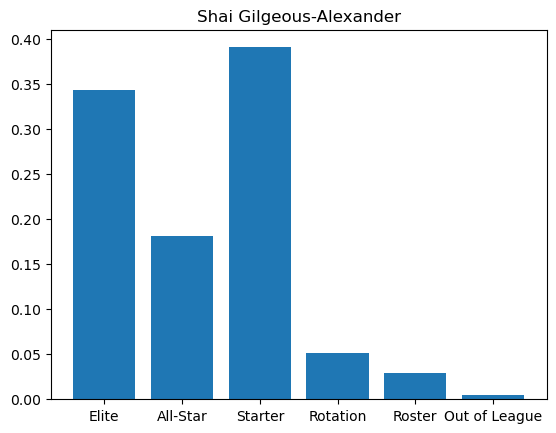

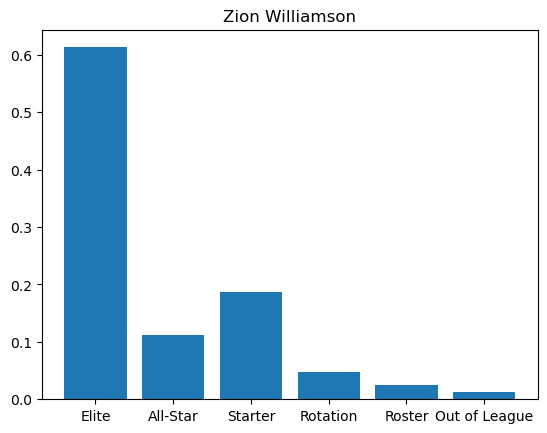

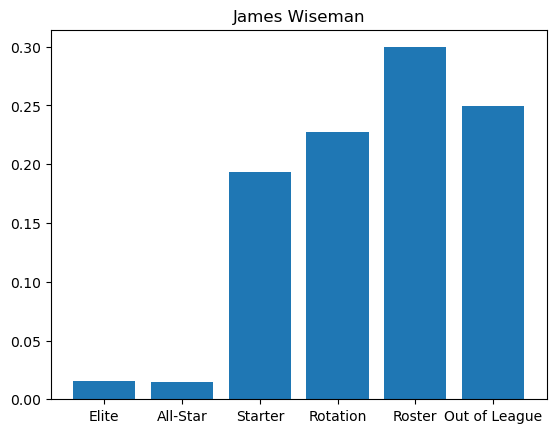

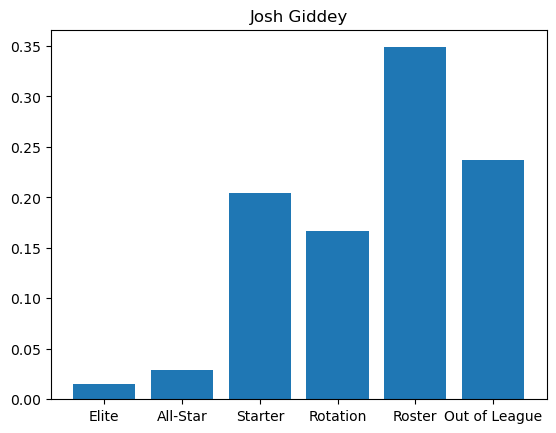

,Elite,All-Star,Starter,Rotation,Roster,Out of League,draftyear
Shai Gilgeous-Alexander,0.342971,0.180574,0.390297,0.051638,0.029302,0.005218,2018
Zion Williamson,0.613157,0.112512,0.187152,0.048128,0.025655,0.013396,2019
James Wiseman,0.015264,0.014447,0.193342,0.227571,0.299485,0.249892,2020
Josh Giddey,0.015299,0.028797,0.203891,0.166354,0.348635,0.237024,2021


In [13]:
# Use fitted weights to predict on test data
coefs = np.array([x[i:i+X.shape[1]] for i in range(0, X.shape[1]*5, X.shape[1])])
intercepts = np.array(x[X.shape[1]*5:])

# Gather cumulative probabilities
preds = sigmoid(np.array(scaled_X_test)@coefs.T+intercepts)
elite = preds[:,0]*preds[:,1]*preds[:,2]*preds[:,3]*preds[:,4]
all_star = elite/preds[:,0]
starter = all_star/preds[:,1]
rotation = starter/preds[:,2]
roster = preds[:,4]
preds = np.vstack([elite, all_star, starter, rotation, roster]).T
preds = pd.DataFrame(preds, index=scaled_X_test.index, columns=buckets)
test_data.index = test_data['player']

# Convert cumulative probabilities to individual probabilities
preds['All-Star'] -= preds['Elite']
preds['Starter'] -= preds['Elite']+preds['All-Star']
preds['Rotation'] -= preds['Elite']+preds['All-Star']+preds['Starter']
preds['Roster'] -= preds['Elite']+preds['All-Star']+preds['Starter']+preds['Rotation']
preds['Out of League'] = 1 - (preds['Elite']+preds['All-Star']+preds['Starter']+preds['Rotation']+preds['Roster'])

# Add a draftyear column to investigate if any classes are shown bias
preds['draftyear'] = test_data.drop_duplicates('player').loc[preds.index]['draftyear']

# Arbitrary sorting of predictions based on ALl-Star or above probability
preds['All-Star+'] = preds['All-Star']+preds['Elite']
preds = preds.sort_values('All-Star+', ascending=False).drop('All-Star+', axis=1)

# Display probabilities for specified players
specified = preds.loc[['Shai Gilgeous-Alexander', 'Zion Williamson', 'James Wiseman', 'Josh Giddey']]
for index, row in specified.iterrows():
    plt.bar(buckets+['Out of League'], row[:-1])
    plt.title(index)
    plt.show()
specified

In [14]:
# Simple display of predicted success rates for each threshold for each class
for bucket in buckets:
    print(bucket)
    for year in range(2018, 2022):
        filt = preds.query('draftyear == @year')
        print(year, filt[bucket].mean())
    print()

Elite
2018 0.028818227418243903
2019 0.01836042275748593
2020 0.014116955126309214
2021 0.02250180454571267

All-Star
2018 0.016724795790767265
2019 0.014156710060405647
2020 0.016381763430873907
2021 0.020358447013557178

Starter
2018 0.13718109303614132
2019 0.13161882576441694
2020 0.12635611819451478
2021 0.1358366306221753

Rotation
2018 0.13137978700262085
2019 0.12867599226105234
2020 0.12163351115287759
2021 0.10559250302600454

Roster
2018 0.16866712193231997
2019 0.1839338315642934
2020 0.1735780773199636
2021 0.16387701348457515



In [15]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
preds.query('draftyear >= 2019')

<IPython.core.display.Javascript object>

Elite  All-Star   Starter  Rotation    Roster  \
Zion Williamson  0.613157  0.112512  0.187152  0.048128  0.025655   
Ja Morant        0.358176  0.222448  0.324889  0.044859  0.044914   
LaMelo Ball      0.226248  0.235420  0.368354  0.094255  0.072876   
Alperen Şengun   0.211254  0.111958  0.381363  0.138508  0.111006   
Evan Mobley      0.205282  0.101174  0.531868  0.104103  0.051000   
...                   ...       ...       ...       ...       ...   
Didi Louzada     0.000091  0.000187  0.005715  0.014726  0.059303   
Brian Bowen II   0.000114  0.000163  0.004907  0.012814  0.042843   
Shaq Buchanan    0.000110  0.000155  0.002544  0.002696  0.011364   
Zylan Cheatham   0.000075  0.000127  0.003833  0.012124  0.039515   
Kyle Alexander   0.000054  0.000079  0.002390  0.008535  0.028126   

                 Out of League  draftyear  
Zion Williamson       0.013396       2019  
Ja Morant             0.004713       2019  
LaMelo Ball           0.002847       2020  
Alperen Şengun        0.045910       2021  
Evan Mobley           0.006573       2021  
...                        ...        ...  
Didi Louzada          0.919978       2019  
Brian Bowen II        0.939158       2019  
Shaq Buchanan         0.983131       2019  
Zylan Cheatham        0.944326       2019  
Kyle Alexander        0.960816       2019  

[293 rows x 7 columns]